In [1]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
import teaspoon.MakeData.DynSysLib.DynSysLib as DSL
from scipy.integrate import solve_ivp
from typing import Callable
from scipy import stats
from nolds import lyap_r
from nolds import lyap_e
from teaspoon.SP import network_tools
from teaspoon.SP.network import ordinal_partition_graph
from teaspoon.SP.network import knn_graph
from teaspoon.SP.network import ordinal_partition_graph
from gtda.time_series import takens_embedding_optimal_parameters
from teaspoon.SP.network_tools import remove_zeros
from teaspoon.SP.network_tools import make_network
from teaspoon.SP.tsa_tools import takens
from teaspoon.parameter_selection.MsPE import MsPE_tau
from teaspoon.TDA.Persistence import BettiCurve
from teaspoon.TDA.PHN import DistanceMatrix
from teaspoon.TDA.PHN import PH_network
from teaspoon.TDA.PHN import point_summaries
from LogisticMapDataset import LogisticMapDataset as LMD
from TimeSeriesPersistence import TimeSeriesPersistence as TSP
from TimeSeriesMergeTree import TimeSeriesMergeTree as TSMT
from TimeSeriesHVG import TimeSeriesHVG as TSHVG
from tsph import plot_time_series
from trajectories import generate_trajectories
from plots_and_correlates import get_correlation
from plots_and_correlates import plot_lce_estimate_and_correlation


In [2]:
import ipyparallel as ipp
clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [3]:
SEED = 42
SAMPLES = 500
LENGTHS = [1000, 750, 500]
experimental_data_all = {}
for length in LENGTHS:
    experimental_data_all |= {
        (SEED, length, SAMPLES): generate_trajectories(
            RANDOM_SEED=SEED, TS_LENGTH=length, CONTROL_PARAM_SAMPLES=SAMPLES
        )
    }


Experiment config -- SEED:42, LENGTH:1000, SAMPLES:500
Experiment config -- SEED:42, LENGTH:750, SAMPLES:500
Experiment config -- SEED:42, LENGTH:500, SAMPLES:500


In [4]:
experimental_data = experimental_data_all[42, 1000, 500]

In [5]:
logistic_trajectories = experimental_data["logistic"]["trajectories"]
logistic_lces = experimental_data["logistic"]["lces"]
logistic_control_params = experimental_data["logistic"]["sys_params"]

In [6]:
henon_trajectories = experimental_data["henon"]["trajectories"]
henon_lces = experimental_data["henon"]["lces"]
henon_control_params = experimental_data["henon"]["sys_params"]

In [7]:
ikeda_trajectories = experimental_data["ikeda"]["trajectories"]
ikeda_lces = experimental_data["ikeda"]["lces"]
ikeda_control_params = experimental_data["ikeda"]["sys_params"]

In [8]:
tinkerbell_trajectories = experimental_data["tinkerbell"]["trajectories"]
tinkerbell_lces = experimental_data["tinkerbell"]["lces"]
tinkerbell_control_params = experimental_data["tinkerbell"]["sys_params"]

In [9]:
def DistanceMatrixFixed(A):
    """Get the all-pairs unweighted shortest path lengths in the graph A.

    Does its own imports so it can run on ipyparallel engines.

    Fixes an issue in the `teaspoon` library such that distance matrix computation
    fails with disconnected graphs A.
    """
    import numpy as np
    import networkx as nx
    from teaspoon.SP import network_tools
    
    A = network_tools.remove_zeros(A)
    np.fill_diagonal(A, 0)
    A = A + A.T

    A_sp = np.copy(A)
    N = len(A_sp)
    D = np.zeros((N,N))

    A_sp[A_sp > 0] = 1
    G = nx.from_numpy_matrix(A_sp)
    lengths = dict(nx.all_pairs_shortest_path_length(G))    
    for i in range(N-1):
        for j in range(i+1, N):
            D[i][j] = lengths.get(i, {}).get(j, np.inf)
    D = D + D.T
    return D



In [10]:
def get_best_params(ts, max_delay=50, max_dim=8):
    delay, dim = takens_embedding_optimal_parameters(ts, max_delay, max_dim)
    return delay, dim

In [11]:
optimal_embedding_params = [
    takens_embedding_optimal_parameters(ts, max_dimension=8, max_time_delay=50)
    for ts in logistic_trajectories
]


In [12]:

embeddings = [
    takens(ts, n=dim, tau=tau)
    for ts, (tau, dim) in zip(logistic_trajectories, optimal_embedding_params)
]


In [13]:

knn_graphs = []

for ts, embed in zip(logistic_trajectories, optimal_embedding_params):
    tau, dim = embed
    graph = knn_graph(ts, n=dim, tau=tau, k=4)
    graph = remove_zeros(graph)
    knn_graphs.append(graph)


In [14]:
opn_graphs = []

for ts in logistic_trajectories:
    graph = ordinal_partition_graph(ts)
    graph = remove_zeros(graph)
    opn_graphs.append(graph)

In [15]:

# distance_matrices = [DistanceMatrixFixed(A) for A in knn_graphs]
distance_matrices = lbv.map_sync(DistanceMatrixFixed, knn_graphs)


In [16]:

# knn_diagrams = [PH_network(D) for D in distance_matrices]
knn_diagrams = lbv.map_sync(PH_network, distance_matrices)


In [17]:

knn_stats = np.array([point_summaries(diagram, A) for diagram, A in zip(knn_diagrams, knn_graphs)])
knn_stats = np.nan_to_num(knn_stats)



In [18]:
max_persistence_ratio, persistent_entropy_normalised, homology_class_ratio = knn_stats.T

In [19]:
correlations = {}

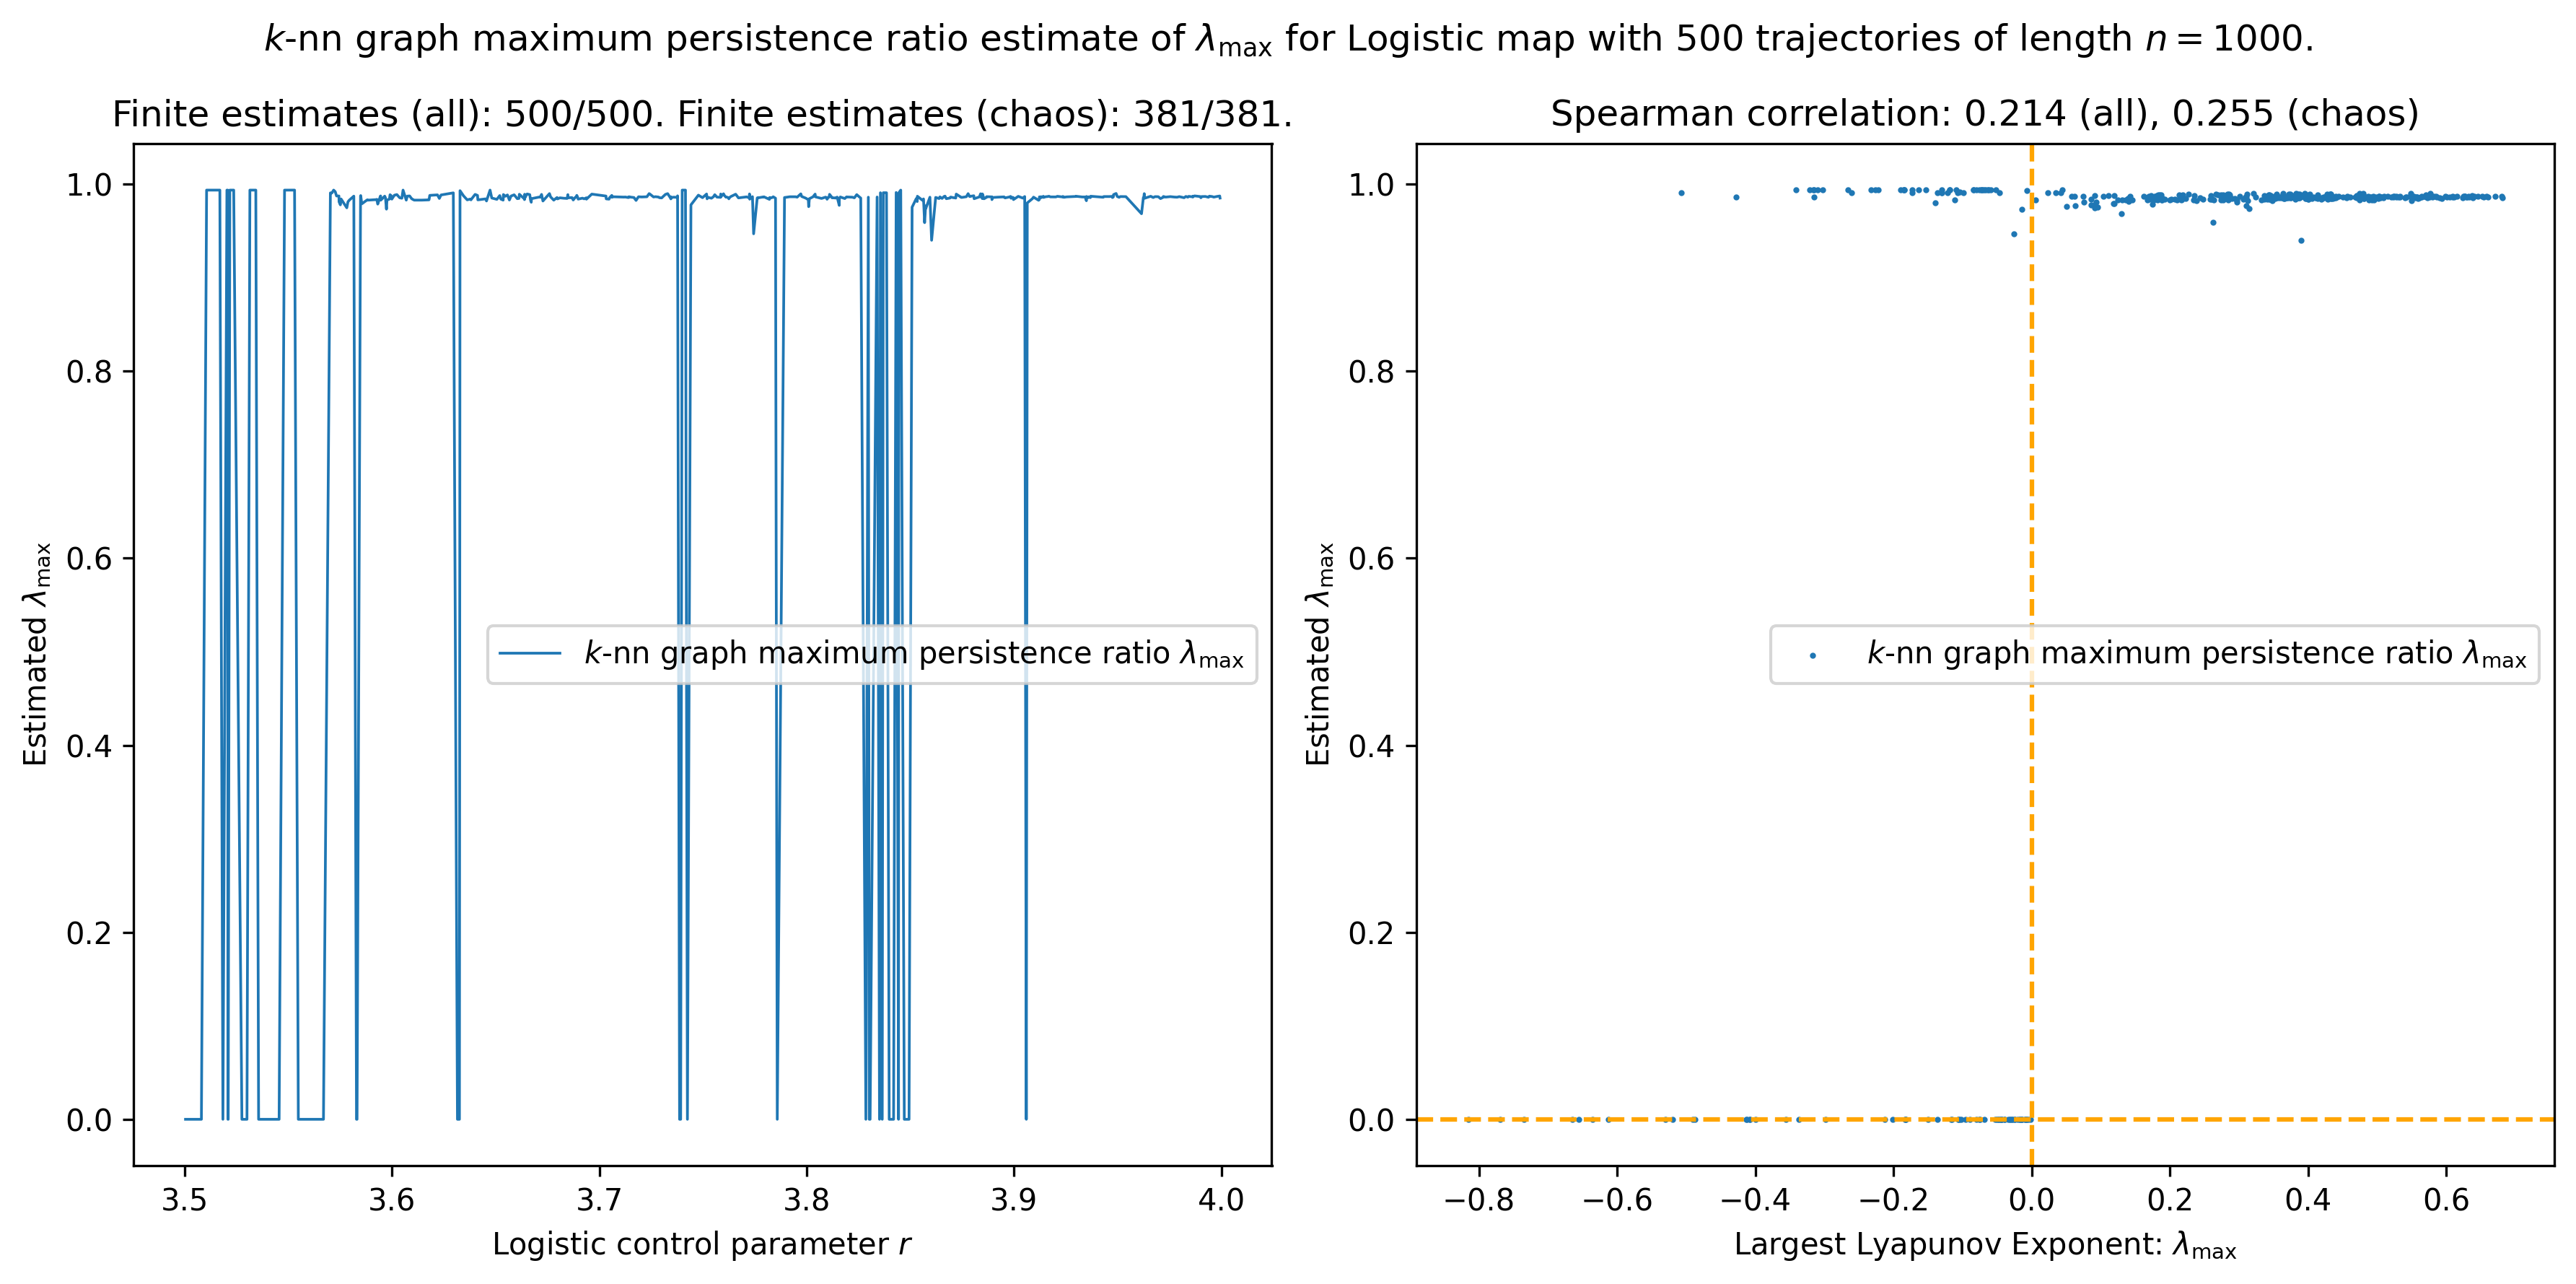

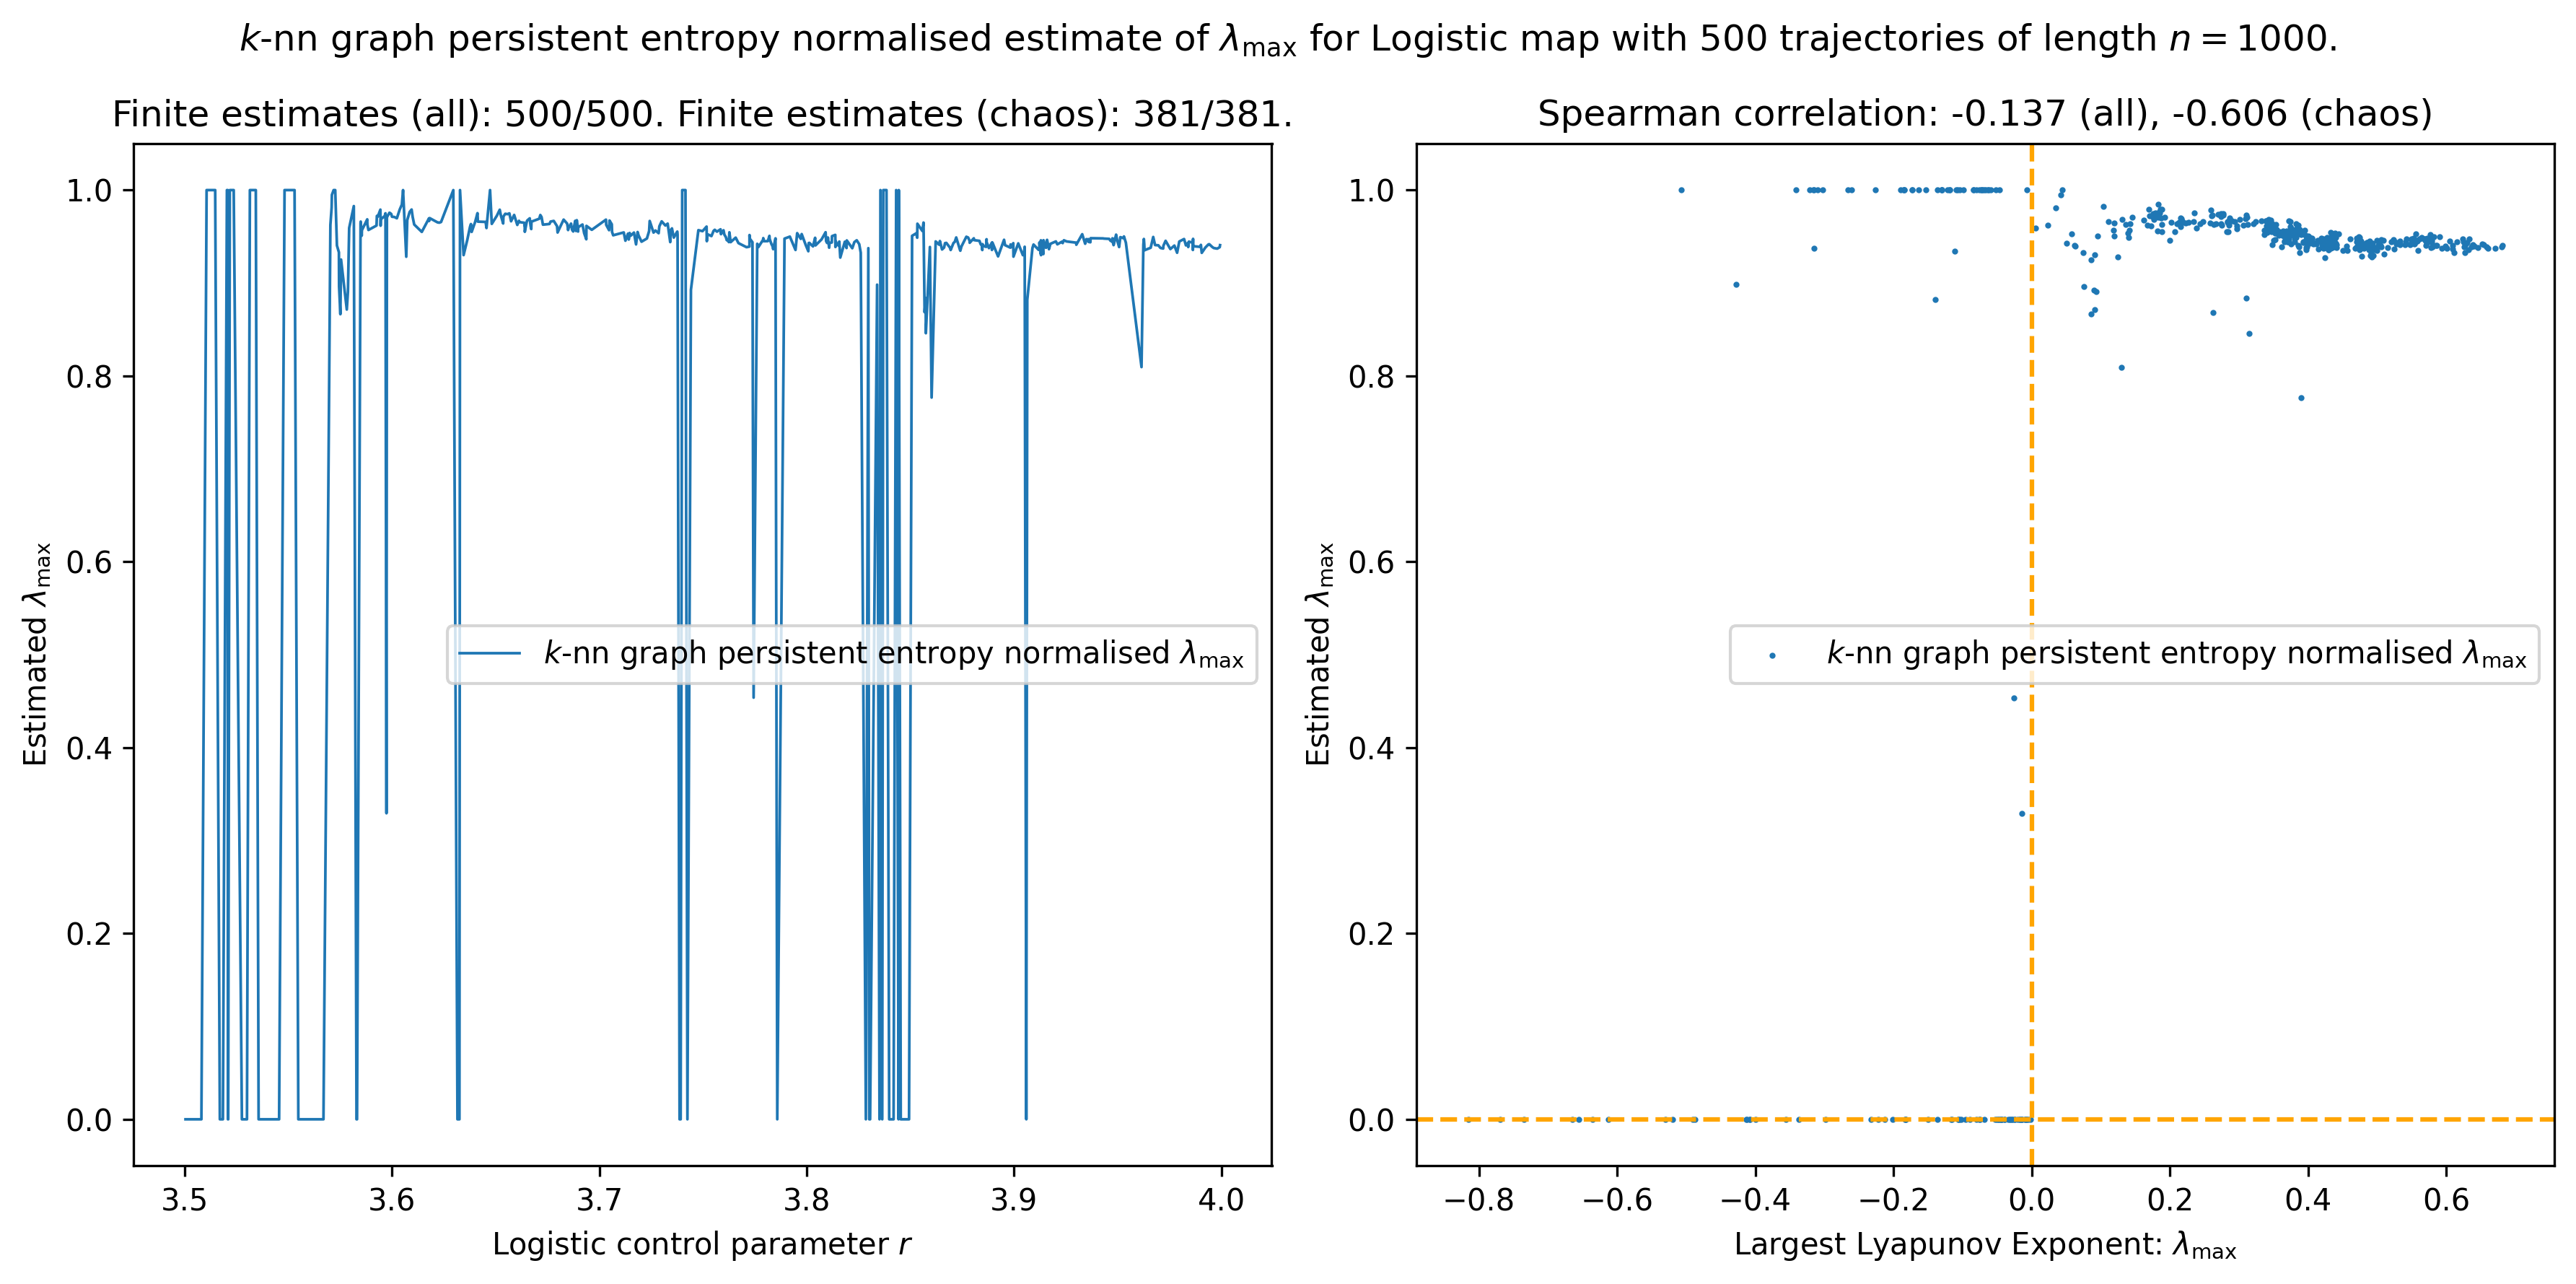

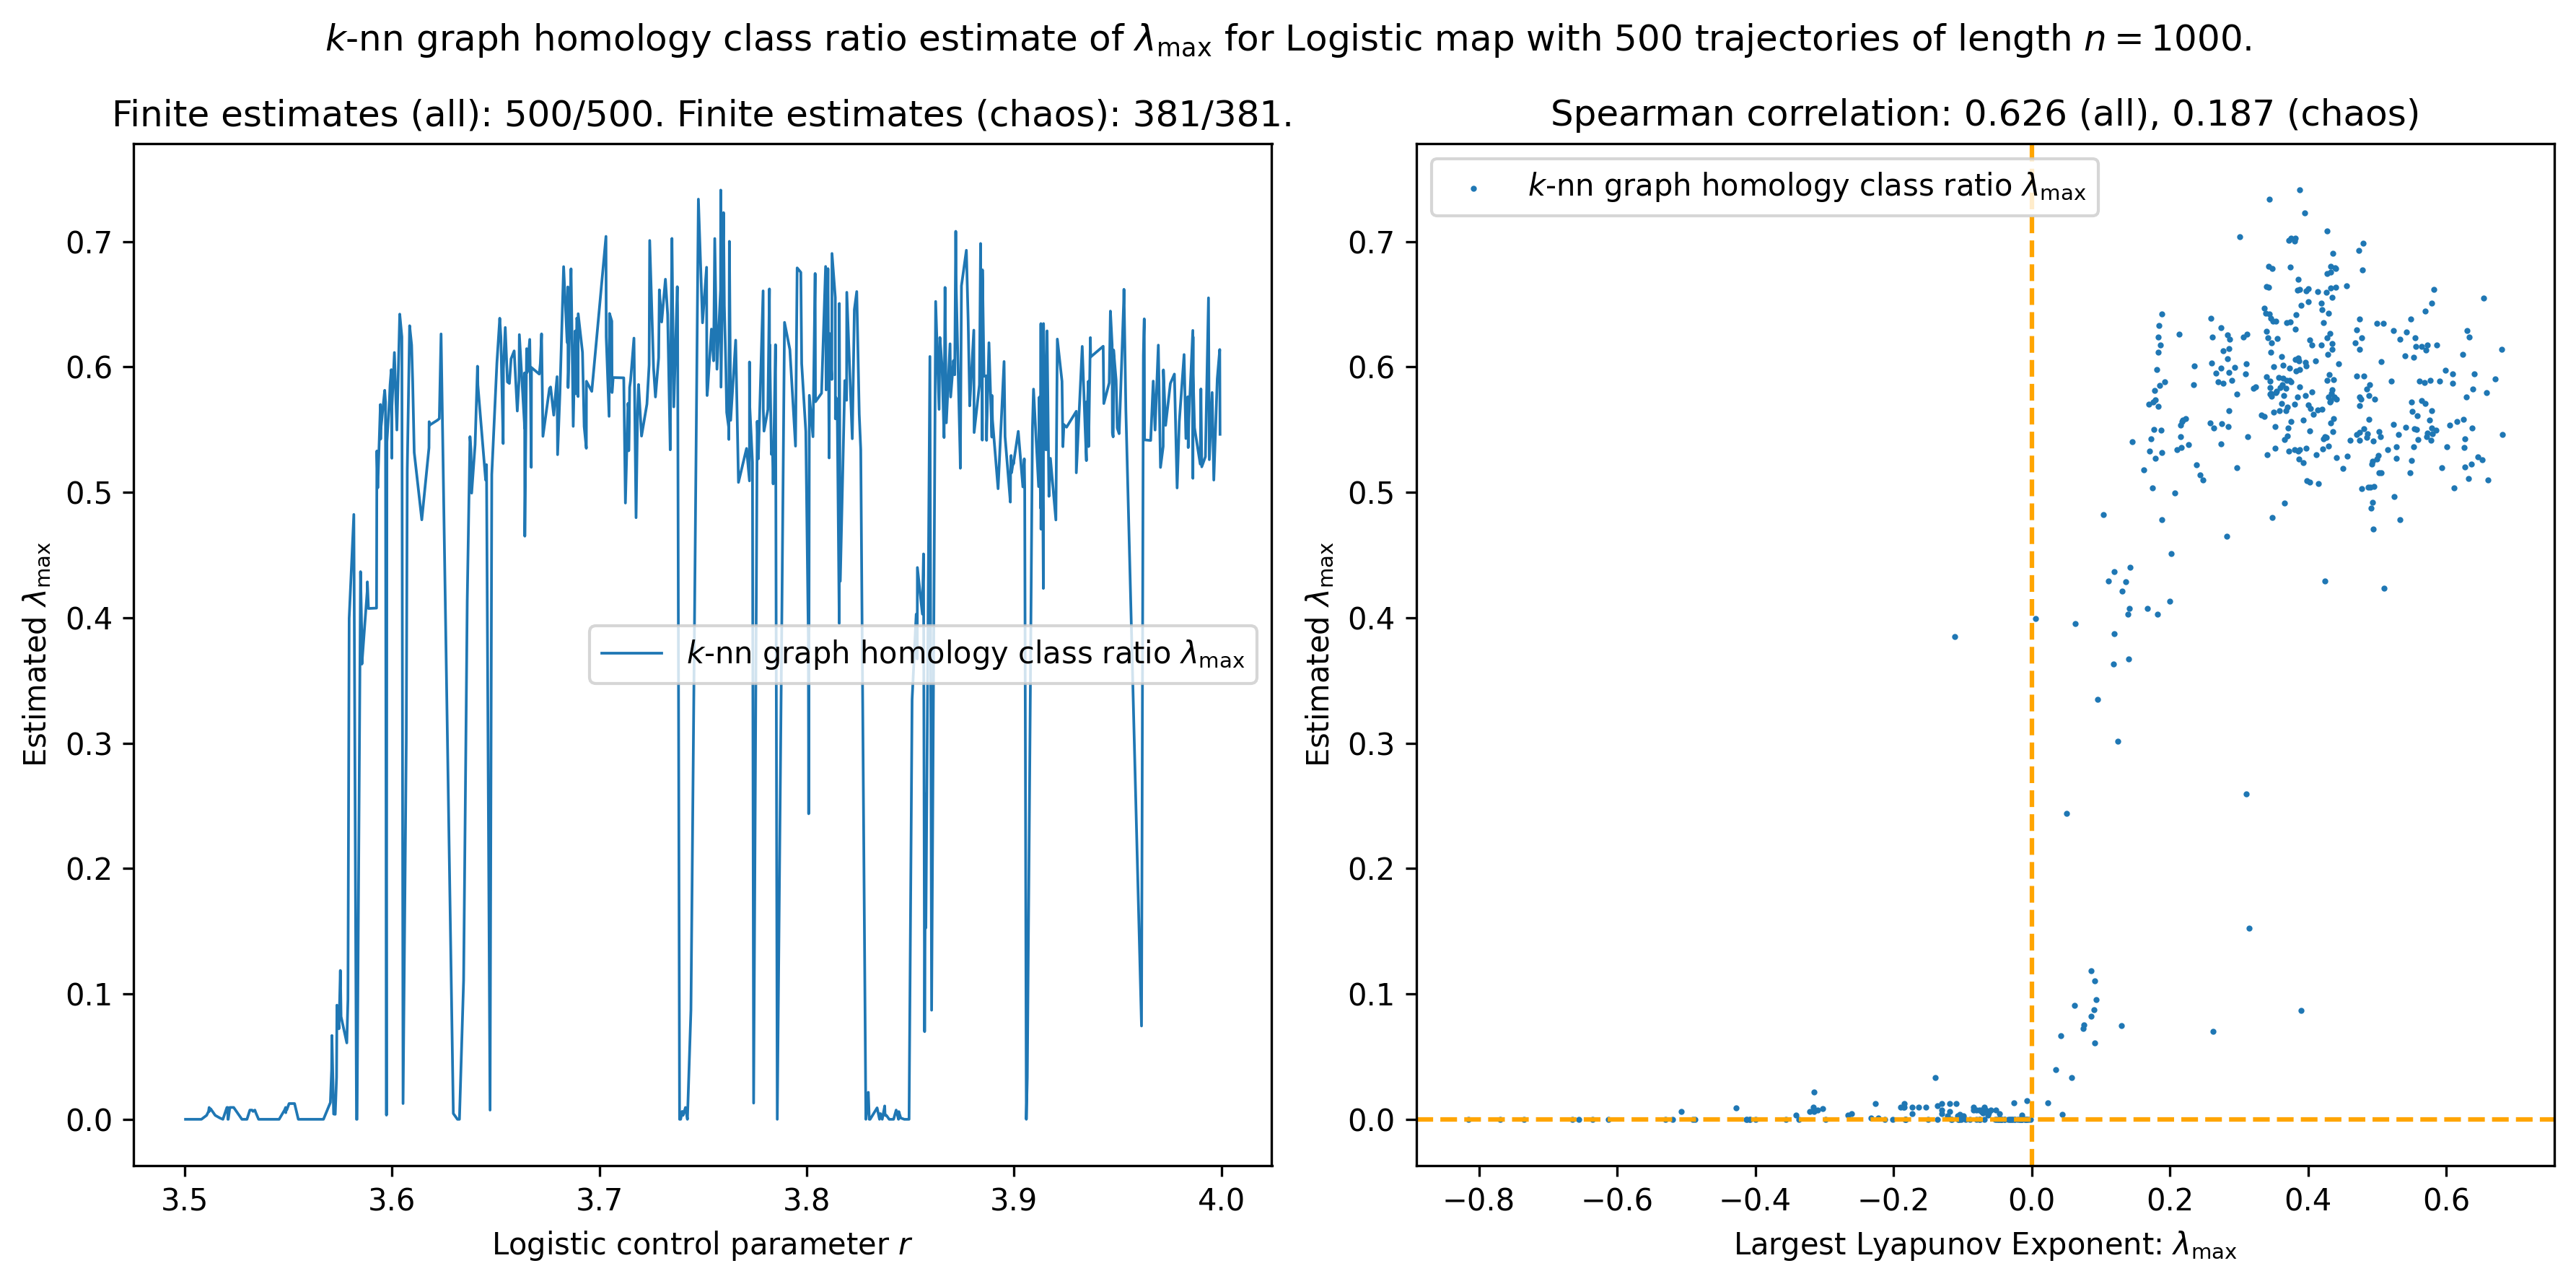

In [20]:
logistic_tda = {
    "$k$-NN graph maximum persistence ratio": max_persistence_ratio,
    "$k$-NN graph persistent entropy normalised": persistent_entropy_normalised,
    "$k$-NN graph homology class ratio": homology_class_ratio,
}
for estimate_name, estimates in logistic_tda.items():
    sequence_length = len(logistic_trajectories[0])-1
    correlations[estimate_name, "Logistic", sequence_length] = plot_lce_estimate_and_correlation(
        estimate_name,
        "Logistic",
        "r",
        estimates,
        logistic_lces,
        logistic_control_params,
        len(logistic_trajectories[0])-1,
        sharey=False,
    )

In [21]:

# distance_matrices = [DistanceMatrixFixed(A) for A in knn_graphs]
distance_matrices_opn = lbv.map_sync(DistanceMatrixFixed, opn_graphs)


In [22]:

# knn_diagrams = [PH_network(D) for D in distance_matrices]
opn_diagrams = lbv.map_sync(PH_network, distance_matrices_opn)


In [23]:
opn_graphs_2d = []
for G in opn_graphs:
    if len(G) > 0:
        opn_graphs_2d.append(G)
    else:
        opn_graphs_2d.append(np.array([[0]]))
knn_stats_opn = np.array([point_summaries(diagram, A) for diagram, A in zip(opn_diagrams, opn_graphs_2d)])
knn_stats_opn = np.nan_to_num(knn_stats_opn)


In [24]:
max_persistence_ratio_opn, persistent_entropy_normalised_opn, homology_class_ratio_opn = knn_stats_opn.T

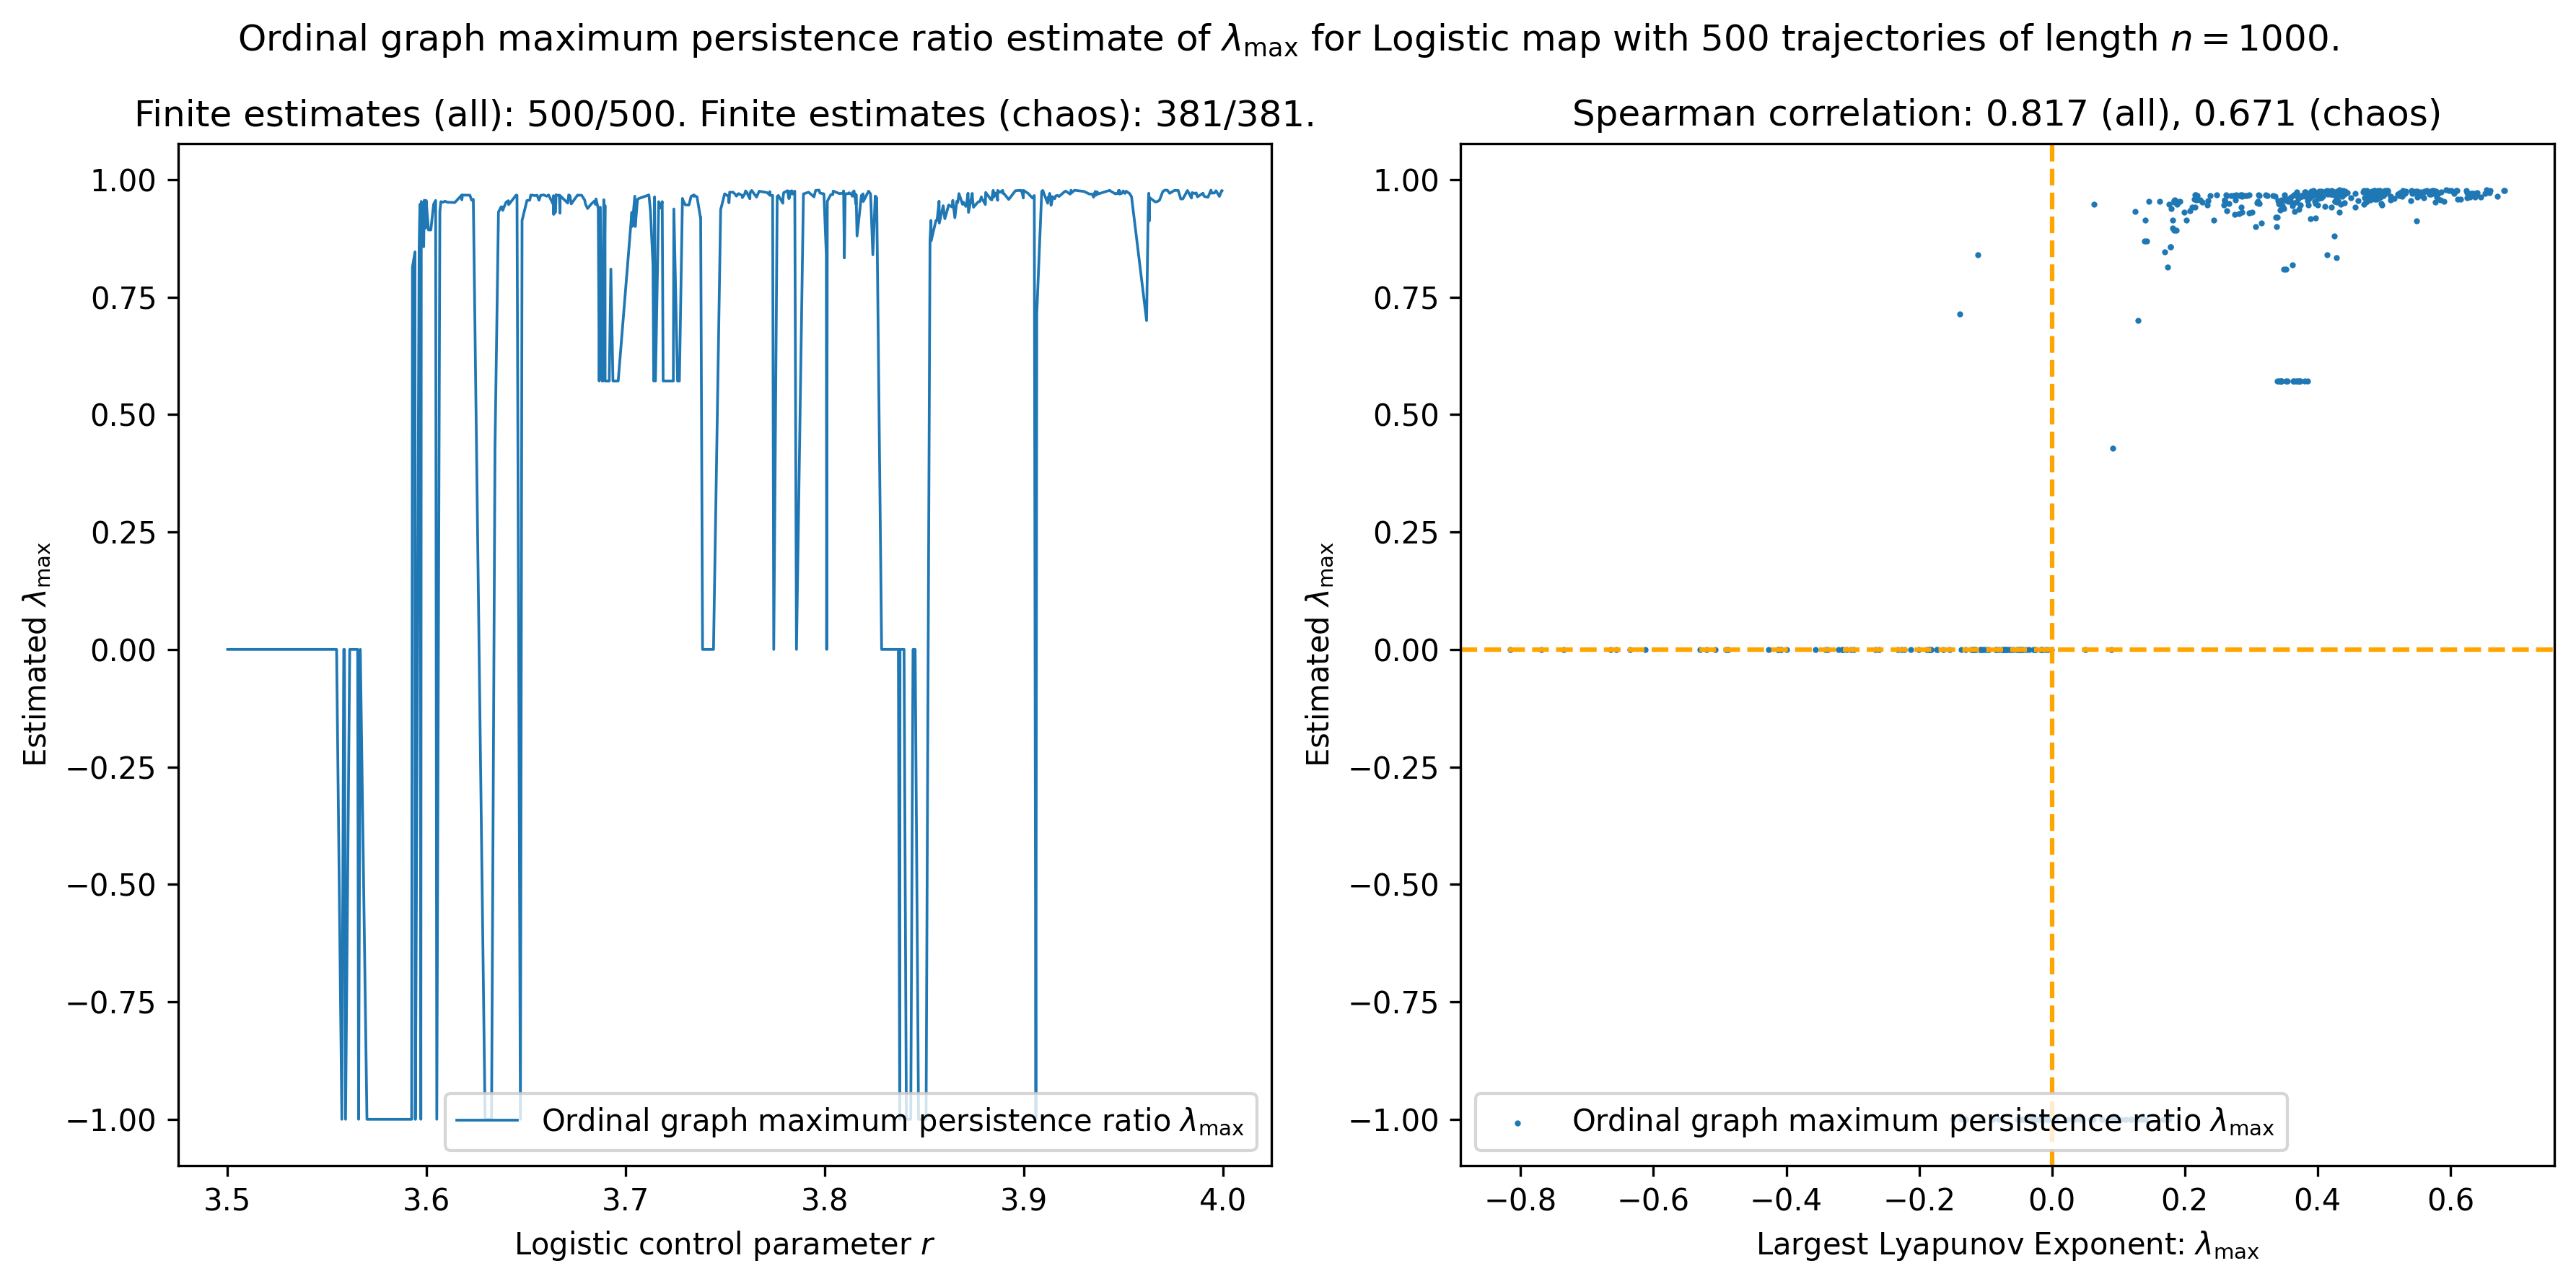

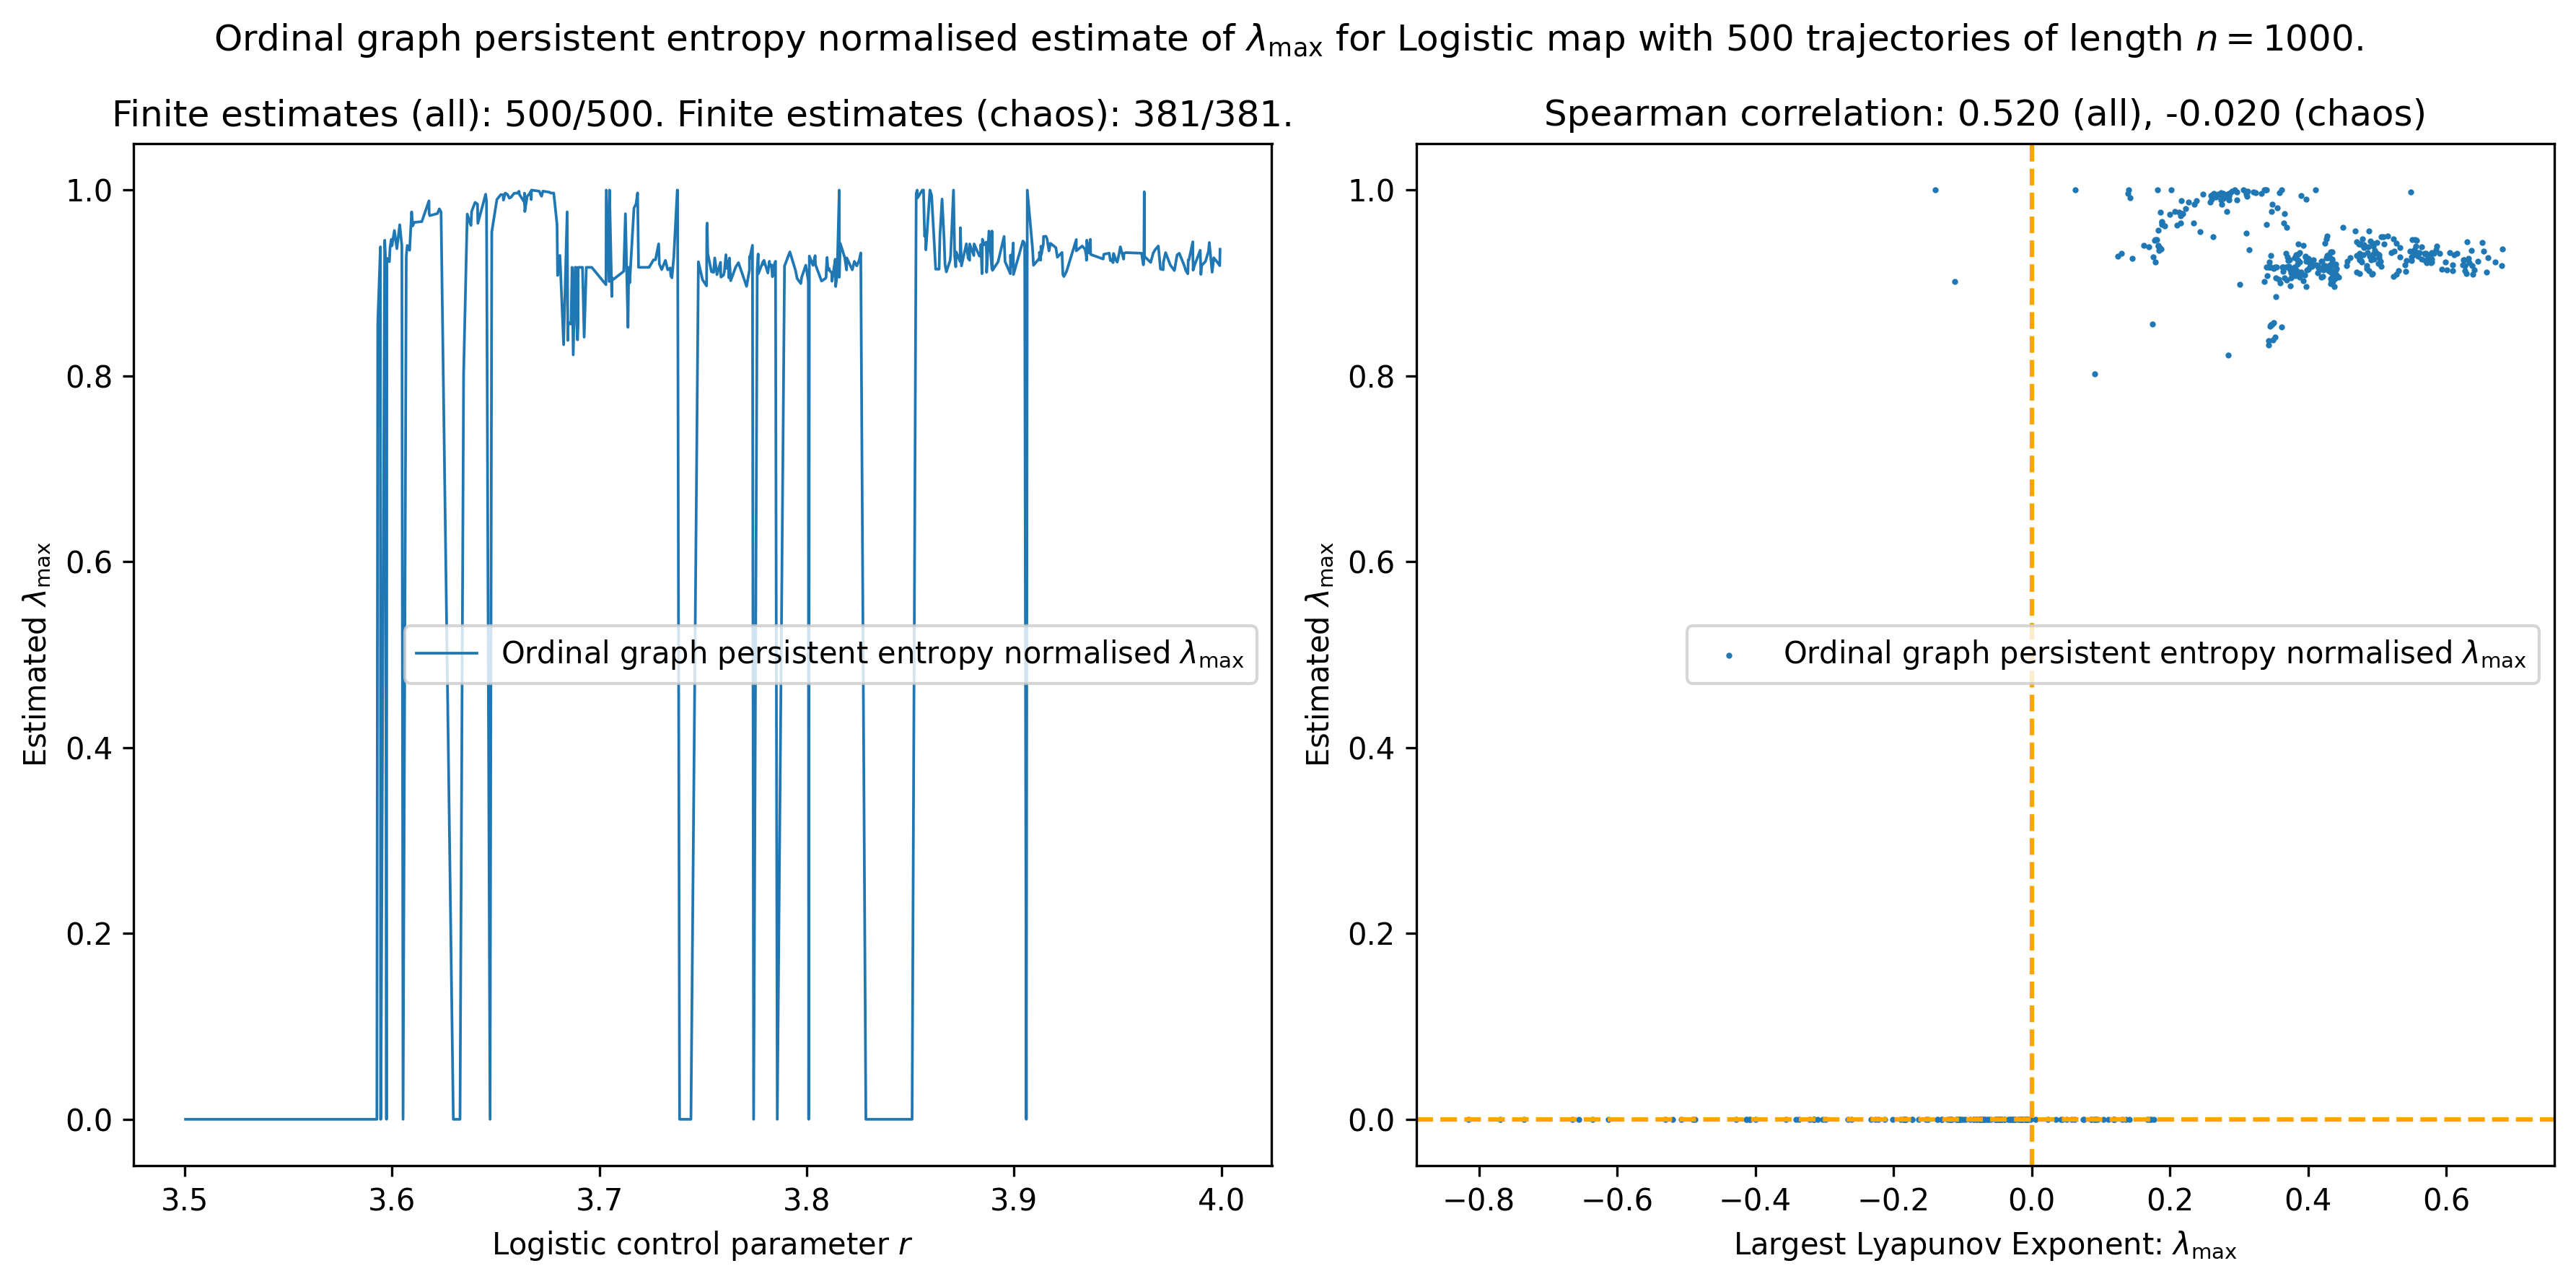

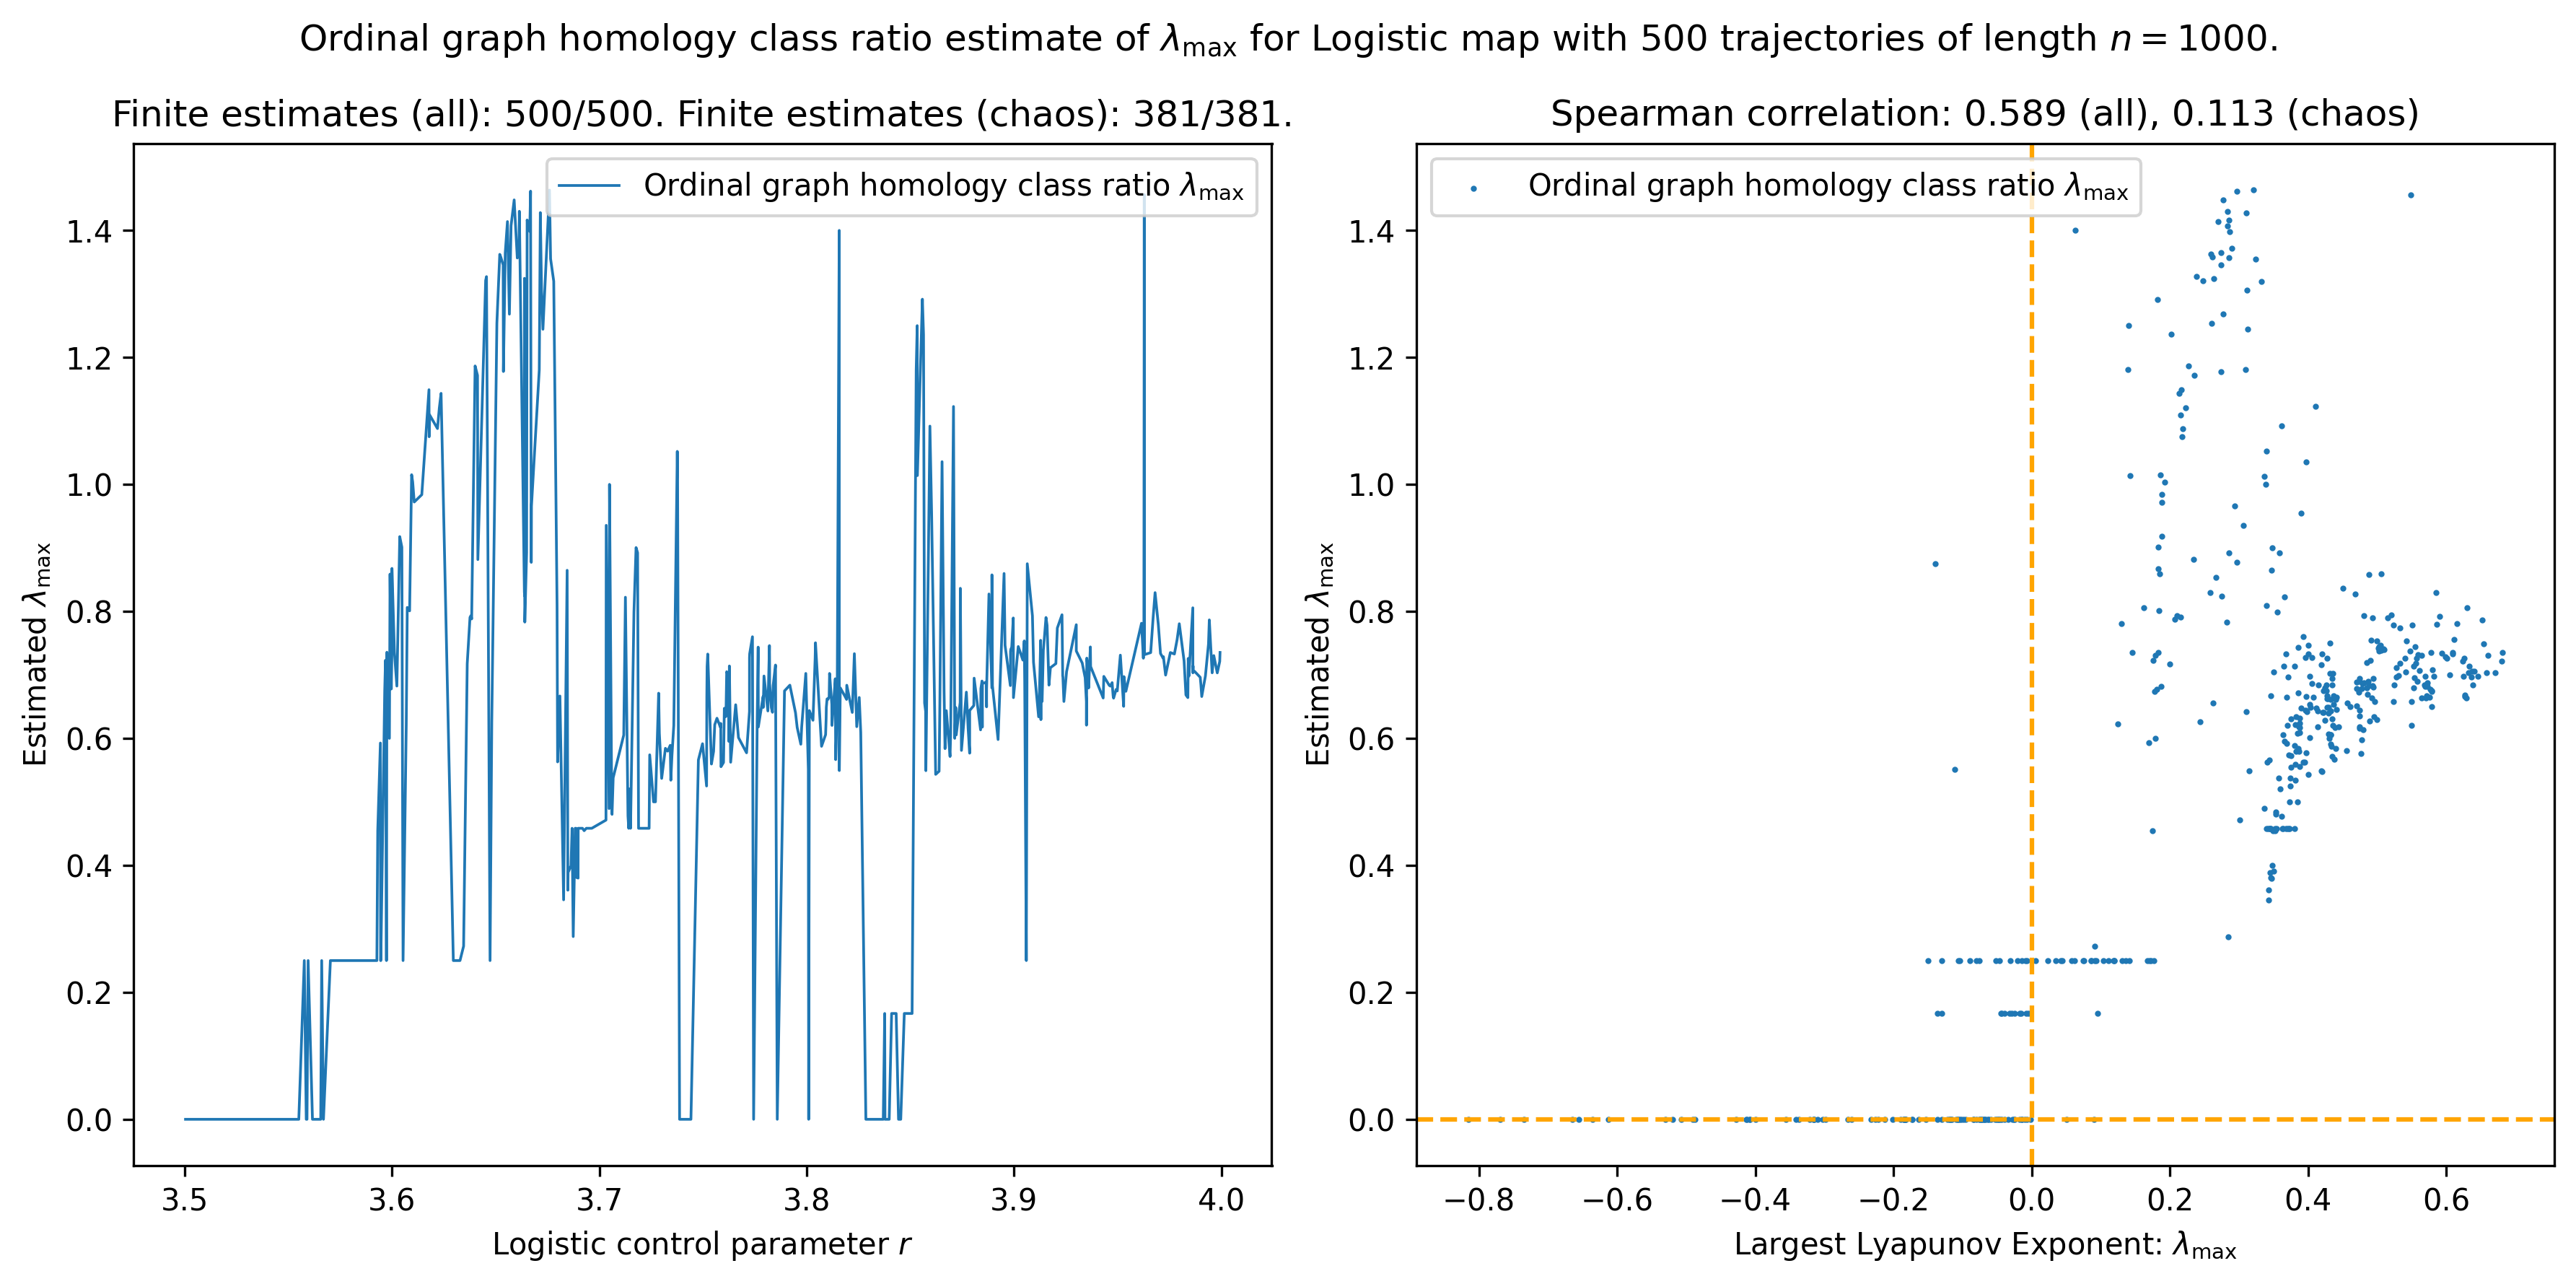

In [25]:
logistic_tda_opn = {
    "Ordinal graph maximum persistence ratio": max_persistence_ratio_opn,
    "Ordinal graph persistent entropy normalised": persistent_entropy_normalised_opn,
    "Ordinal graph homology class ratio": homology_class_ratio_opn,
}
for estimate_name, estimates in logistic_tda_opn.items():
    sequence_length = len(logistic_trajectories[0])-1
    correlations[estimate_name, "Logistic", sequence_length] = plot_lce_estimate_and_correlation(
        estimate_name,
        "Logistic",
        "r",
        estimates,
        logistic_lces,
        logistic_control_params,
        len(logistic_trajectories[0])-1,
        sharey=False,
    )

In [26]:
from pprint import pprint
from json import dumps

In [27]:
pprint(correlations)

{('$k$-NN graph homology class ratio', 'Logistic', 1000): (SpearmanrResult(correlation=0.6255251508011336, pvalue=1.1890285728239346e-55),
                                                           SpearmanrResult(correlation=0.18692396560211463, pvalue=0.00024349064859046572)),
 ('$k$-NN graph maximum persistence ratio', 'Logistic', 1000): (SpearmanrResult(correlation=0.21438990150124024, pvalue=1.3097120772612699e-06),
                                                                SpearmanrResult(correlation=0.25512698608701323, pvalue=4.481367289276662e-07)),
 ('$k$-NN graph persistent entropy normalised', 'Logistic', 1000): (SpearmanrResult(correlation=-0.13731806551095158, pvalue=0.002087936085454057),
                                                                    SpearmanrResult(correlation=-0.605704918601901, pvalue=1.621557602553502e-39)),
 ('Ordinal graph homology class ratio', 'Logistic', 1000): (SpearmanrResult(correlation=0.5885078869155573, pvalue=6.369462399978495e-